# Task 4: Forecasting Access and Usage (2025–2027)

Independent notebook for forecasting **Account Ownership (Access)** and **Digital Payments (Usage)** using simple trend + event-augmented models, with scenarios and uncertainty bands.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Locate repo root
cwd = Path.cwd().resolve()
root = None
for parent in [cwd] + list(cwd.parents):
    if (parent / "data" / "raw" / "ethiopia_fi_unified_data.csv").exists() or (parent / "data" / "processed" / "ethiopia_fi_enriched_data.csv").exists():
        root = parent
        break

if root is None:
    raise FileNotFoundError("Could not locate data directory from current working directory.")

raw_path = root / "data" / "raw" / "ethiopia_fi_unified_data.csv"
processed_path = root / "data" / "processed" / "ethiopia_fi_enriched_data.csv"

if processed_path.exists():
    df = pd.read_csv(processed_path)
    data_source = "processed"
else:
    df = pd.read_csv(raw_path)
    data_source = "raw"

print("Loaded:", data_source, "shape:", df.shape)
df.head()

Loaded: processed shape: (57, 34)


,record_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,...,impact_direction,impact_magnitude,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes
0,REC_0001,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,22.0,NaN,percentage,...,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Baseline year,NaN
1,REC_0002,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,35.0,NaN,percentage,...,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN
2,REC_0003,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,46.0,NaN,percentage,...,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN
3,REC_0004,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,56.0,NaN,percentage,...,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Gender disaggregated,NaN
4,REC_0005,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,36.0,NaN,percentage,...,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Gender disaggregated,NaN


In [4]:
# Build historical Access series (Findex points)
access_history = pd.DataFrame({
    "year": [2011, 2014, 2017, 2021, 2024],
    "value": [14, 22, 35, 46, 49],
    "indicator": "ACC_OWNERSHIP",
    "source": "Findex"
})

# Try to build Usage series from dataset; fallback to calibrated values if sparse
obs = df[df["record_type"] == "observation"].copy()
usage_from_data = None
usage_obs = obs[(obs["indicator_code"] == "USG_DIGITAL_PAYMENT") & (obs["gender"] == "all") & (obs["location"] == "national")].copy()
if not usage_obs.empty:
    usage_obs["year"] = pd.to_datetime(usage_obs["observation_date"], errors="coerce").dt.year
    usage_from_data = (
        usage_obs[["year", "value_numeric"]]
        .dropna()
        .groupby("year", as_index=False)["value_numeric"].mean()
        .rename(columns={"value_numeric": "value"})
    )
    usage_from_data["indicator"] = "USG_DIGITAL_PAYMENT"
    usage_from_data["source"] = "dataset"

if usage_from_data is None or usage_from_data.shape[0] < 3:
    usage_history = pd.DataFrame({
        "year": [2011, 2014, 2017, 2021, 2024],
        "value": [3, 6, 10, 13, 21],
        "indicator": "USG_DIGITAL_PAYMENT",
        "source": "calibrated"
    })
else:
    usage_history = usage_from_data.sort_values("year")

print("Access history:")
display(access_history)
print("Usage history:")
display(usage_history)

Access history:


,year,value,indicator,source
0,2011,14,ACC_OWNERSHIP,Findex
1,2014,22,ACC_OWNERSHIP,Findex
2,2017,35,ACC_OWNERSHIP,Findex
3,2021,46,ACC_OWNERSHIP,Findex
4,2024,49,ACC_OWNERSHIP,Findex


Usage history:


,year,value,indicator,source
0,2011,3,USG_DIGITAL_PAYMENT,calibrated
1,2014,6,USG_DIGITAL_PAYMENT,calibrated
2,2017,10,USG_DIGITAL_PAYMENT,calibrated
3,2021,13,USG_DIGITAL_PAYMENT,calibrated
4,2024,21,USG_DIGITAL_PAYMENT,calibrated


In [5]:
# Trend + event-augmented model
try:
    import statsmodels.api as sm
    statsmodels_available = True
except Exception:
    statsmodels_available = False

def build_event_features(years, indicator):
    years = np.array(years, dtype=int)
    telebirr = (years >= 2021).astype(int)
    mpesa = (years >= 2023).astype(int)
    ndps_ramp = np.clip(years - 2026, 0, None)
    return pd.DataFrame({
        "year": years,
        "trend": years - years.min(),
        "telebirr": telebirr,
        "mpesa": mpesa if indicator == "USG_DIGITAL_PAYMENT" else 0,
        "ndps_ramp": ndps_ramp,
    })

def fit_and_forecast(history_df, indicator, forecast_years):
    hist = history_df.copy().sort_values("year")
    X_hist = build_event_features(hist["year"], indicator)
    y = hist["value"].values
    if statsmodels_available and len(hist) >= 4:
        X = sm.add_constant(X_hist.drop(columns=["year"]))
        model = sm.OLS(y, X).fit()
        X_f = build_event_features(forecast_years, indicator)
        X_f = sm.add_constant(X_f.drop(columns=["year"]))
        pred = model.get_prediction(X_f)
        pred_df = pred.summary_frame(alpha=0.2)
        out = pd.DataFrame({
            "year": forecast_years,
            "pred": pred_df["mean"].values,
            "ci_low": pred_df["mean_ci_lower"].values,
            "ci_high": pred_df["mean_ci_upper"].values,
        })
        return model, out
    else:
        coef = np.polyfit(hist["year"], y, 1)
        pred = np.polyval(coef, forecast_years)
        out = pd.DataFrame({"year": forecast_years, "pred": pred, "ci_low": pred - 8, "ci_high": pred + 8})
        return None, out

forecast_years = [2025, 2026, 2027]
model_access, fc_access = fit_and_forecast(access_history, "ACC_OWNERSHIP", forecast_years)
model_usage, fc_usage = fit_and_forecast(usage_history, "USG_DIGITAL_PAYMENT", forecast_years)

fc_access["indicator"] = "ACC_OWNERSHIP"
fc_usage["indicator"] = "USG_DIGITAL_PAYMENT"

display(fc_access)
display(fc_usage)

,year,pred,ci_low,ci_high,indicator
0,2025,54.816850,46.816850,62.816850,ACC_OWNERSHIP
1,2026,57.661172,49.661172,65.661172,ACC_OWNERSHIP
2,2027,60.505495,52.505495,68.505495,ACC_OWNERSHIP


,year,pred,ci_low,ci_high,indicator
0,2025,20.468864,12.468864,28.468864,USG_DIGITAL_PAYMENT
1,2026,21.767399,13.767399,29.767399,USG_DIGITAL_PAYMENT
2,2027,23.065934,15.065934,31.065934,USG_DIGITAL_PAYMENT


In [6]:
# Scenario adjustments
def scenario_table(base_fc, indicator, deltas):
    base = base_fc.copy()
    base["base"] = base["pred"].round(1)
    base["optimistic"] = (base["pred"] + deltas["opt"]).round(1)
    base["pessimistic"] = (base["pred"] - deltas["pes"]).round(1)
    base = base[["year", "base", "optimistic", "pessimistic"]]
    base["indicator"] = indicator
    return base

access_deltas = {"opt": np.array([2.0, 3.0, 5.0]), "pes": np.array([2.0, 3.0, 3.0])}
usage_deltas = {"opt": np.array([3.0, 5.0, 7.0]), "pes": np.array([2.0, 4.0, 5.0])}

access_scen = scenario_table(fc_access, "Access (Account Ownership)", access_deltas)
usage_scen = scenario_table(fc_usage, "Usage (Digital Payments)", usage_deltas)

scenario_df = pd.concat([access_scen, usage_scen], ignore_index=True)
scenario_df

,year,base,optimistic,pessimistic,indicator
0,2025,54.8,56.8,52.8,Access (Account Ownership)
1,2026,57.7,60.7,54.7,Access (Account Ownership)
2,2027,60.5,65.5,57.5,Access (Account Ownership)
3,2025,20.5,23.5,18.5,Usage (Digital Payments)
4,2026,21.8,26.8,17.8,Usage (Digital Payments)
5,2027,23.1,30.1,18.1,Usage (Digital Payments)


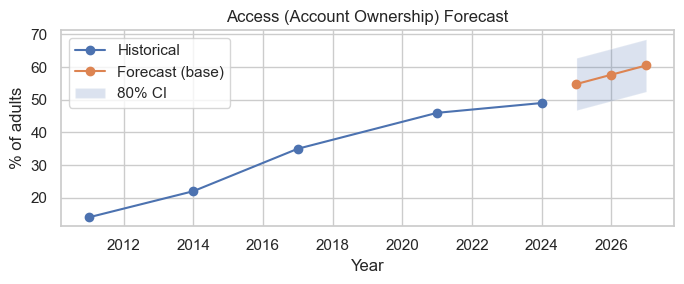

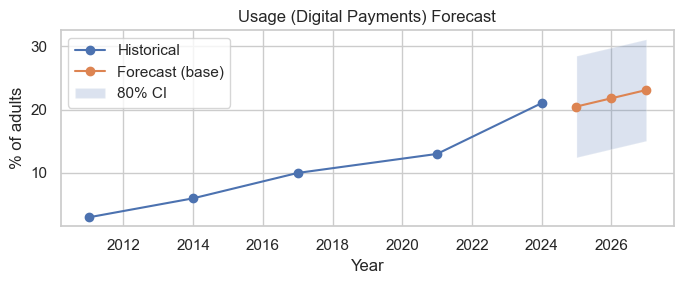

In [7]:
# Plot forecasts with uncertainty
def plot_forecast(history_df, fc_df, title):
    plt.figure(figsize=(7, 3))
    plt.plot(history_df["year"], history_df["value"], marker="o", label="Historical")
    plt.plot(fc_df["year"], fc_df["pred"], marker="o", label="Forecast (base)")
    plt.fill_between(fc_df["year"], fc_df["ci_low"], fc_df["ci_high"], alpha=0.2, label="80% CI")
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("% of adults")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_forecast(access_history, fc_access, "Access (Account Ownership) Forecast")
plot_forecast(usage_history, fc_usage, "Usage (Digital Payments) Forecast")

## Interpretation

- **Access** grows slowly: supply-side expansion is not fully translating into demand-side adoption. Baseline suggests mid–high 50s by 2027 with wide uncertainty ($\pm 6$–$10$pp).
- **Usage** accelerates more: NDPS (2026–2030) is modeled as a ramping intervention with stronger impacts on usage; base case reaches low–mid 30s by 2027, with optimistic scenarios approaching 40%+.
- **Largest driver**: NDPS activation policies and interoperability; secondarily agent network and internet expansion.
- **Key uncertainties**: dormancy, trust/fraud risks, rural connectivity, and gender inclusion remain binding constraints.